# History of decentralized irrigation

This notebook has the goal of answering the question: from 2000 to 2015, does the Mehta and Meier data show irrigation expansion moving away from dams? 

For each irrigation pixel in every year I can get, I need: 
- the irrigation percent
- the distance to the nearest dam (ideally nearest upstream dam)
- the country it's in, for controls

Regression: 
- Does the year explain the distance to the nearest dam (with irrigation percent weights)

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point
import geopandas as gpd
# import seaborn as sns
import rasterio

data_loc = '/home/waves/data/Africa_Irrigation/Data'
raw_data_dir = os.path.join(data_loc, 'anna', 'raw')
years = range(1980, 2016, 5)

In [2]:
# read in the mehta data. Specifically only read in the columns we need: lat, lon, year, aei, distance to dam, and name (country)
source = 'Mehta'
all_aei = []
for year in years: 
    aei_path = os.path.join(data_loc, 'anna', 'intermediate', 'aei_with_dams', f'{source}_aei_{year}.shp')
    aei = gpd.read_file(aei_path, usecols=['Longitude', 'Latitude', 'Year', 'AEI', 'name', 'in_ssa', 'distance_t'])
    aei = aei.rename(columns={'name': 'country', 'distance_t': 'distance_to_dam_km'})
    all_aei.append(aei)

In [13]:
all_aei_combined = pd.concat(all_aei, ignore_index=True)

# How irrigation distance to dams has been changing over time in SSA

In [ ]:
aei_in_ssa = all_aei_combined[all_aei_combined['in_ssa'] == '1']

In [36]:
model = smf.wls('distance_to_dam_km ~ C(Year) + C(country)', data=aei_in_ssa, weights=aei_in_ssa['AEI']).fit()

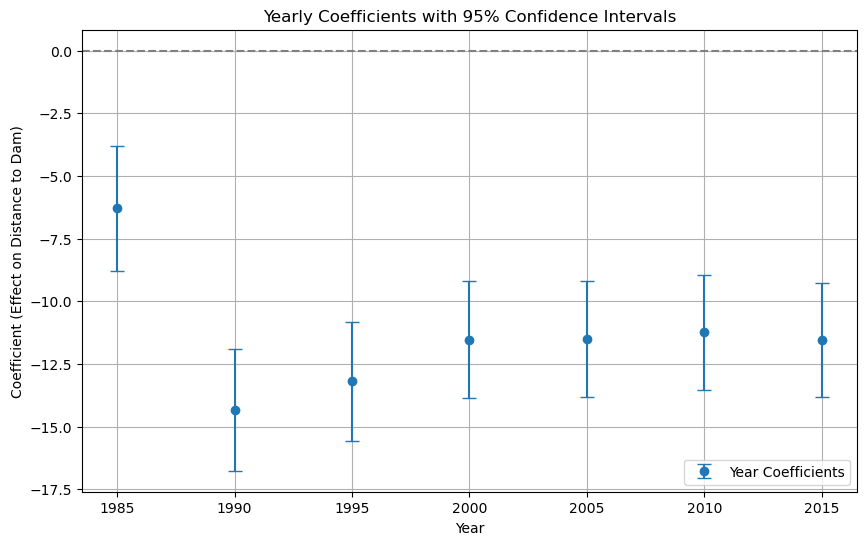

In [60]:
# Step 2: Extract the coefficients and confidence intervals for Year
year_coeffs = model.params.filter(like='C(Year)')
year_conf_int = model.conf_int().loc[model.conf_int().index.str.contains('Year')]

# Correcting the year labels by stripping 'T.'
years = [int(term.split('T.')[1].split(']')[0]) for term in year_coeffs.index]

# Extract lower and upper bounds of confidence intervals
ci_lower = year_conf_int[0].values
ci_upper = year_conf_int[1].values

# Step 3: Plot the coefficients with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(years, year_coeffs.values, yerr=[year_coeffs.values - ci_lower, ci_upper - year_coeffs.values], fmt='o', capsize=5, label='Year Coefficients')
plt.axhline(0, color='grey', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Change in Distance to Dam (km)')
plt.title('Sub-Saharan Africa: Change in Irrigation Distance to Dam (km) relative to 1980')
plt.grid(True)
plt.legend()
plt.show()

# How irrigation distance to dams has been changing over time globally

In [61]:
model = smf.wls('distance_to_dam_km ~ C(Year) + C(country)', data=all_aei_combined, weights=all_aei_combined['AEI']).fit()

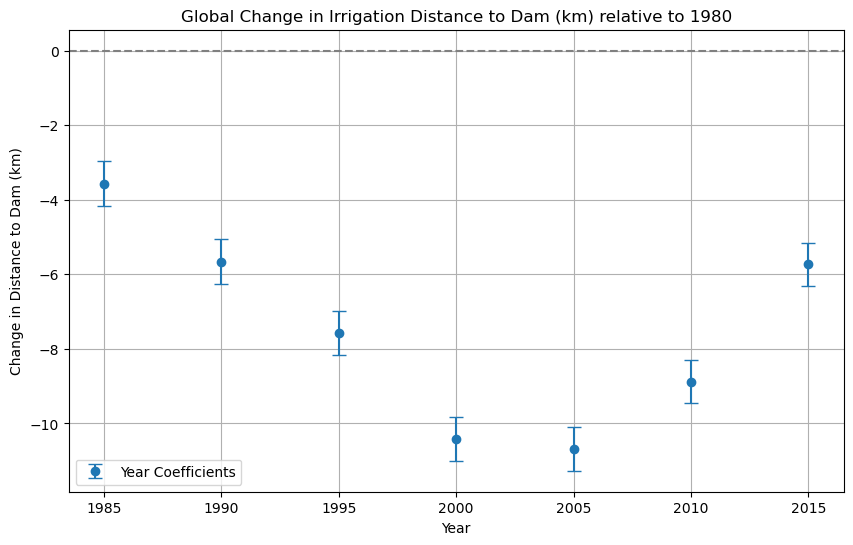

In [62]:
# Step 2: Extract the coefficients and confidence intervals for Year
year_coeffs = model.params.filter(like='C(Year)')
year_conf_int = model.conf_int().loc[model.conf_int().index.str.contains('Year')]

# Correcting the year labels by stripping 'T.'
years = [int(term.split('T.')[1].split(']')[0]) for term in year_coeffs.index]

# Extract lower and upper bounds of confidence intervals
ci_lower = year_conf_int[0].values
ci_upper = year_conf_int[1].values

# Step 3: Plot the coefficients with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(years, year_coeffs.values, yerr=[year_coeffs.values - ci_lower, ci_upper - year_coeffs.values], fmt='o', capsize=5, label='Year Coefficients')
plt.axhline(0, color='grey', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Change in Distance to Dam (km)')
plt.title('Global Change in Irrigation Distance to Dam (km) relative to 1980')
plt.grid(True)
plt.legend()
plt.show()

# Distance to dams trend from 2005 to 2015 -- globally and by country

In [73]:
# Filter the data to only include years 2005 to 2015
aei_2005_2015 = all_aei_combined[(all_aei_combined['Year'] >= 2005) & (all_aei_combined['Year'] <= 2015)]
model = smf.wls('distance_to_dam_km ~ Year + C(country)', data=aei_2005_2015, weights=aei_2005_2015['AEI']).fit()

In [74]:
print(f"Global annual change in distance of irrigation to dams (2005-2015): {model.params['Year']}")
print(f"Year p-value: {model.pvalues['Year']}")
print(f"Year 95% confidence interval: {model.conf_int().loc['Year']}")

Year    0.457096
dtype: float64

In [75]:
# Load the country boundaries
world_boundaries_path = os.path.join(raw_data_dir, 'world_boundaries', 'world-administrative-boundaries.shp')
world_boundaries = gpd.read_file(world_boundaries_path)

In [76]:
# What part of the globe is driving the upward trend from 2005 to 2015? 

# Run the regression but allow for interaction between year and country -- assume linear trend from 2005 to 2015
model = smf.wls('distance_to_dam_km ~ Year * C(country)', data=aei_2005_2015, weights=aei_2005_2015['AEI']).fit()

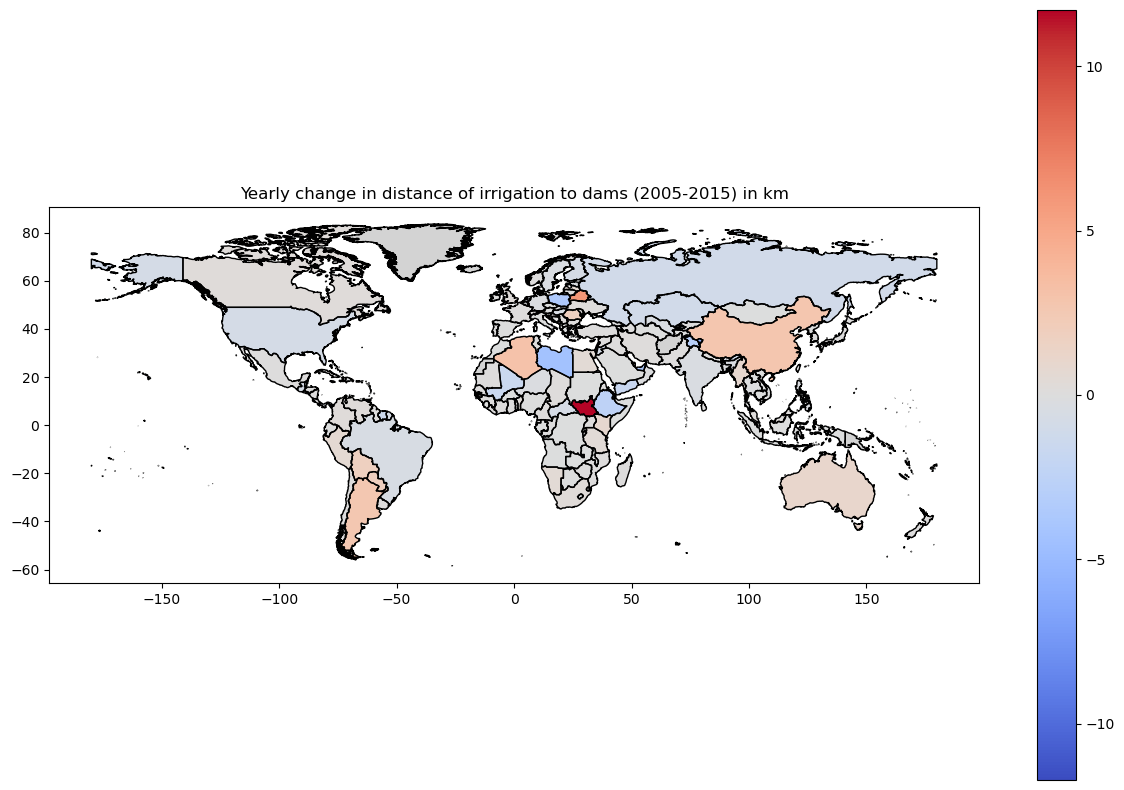

In [77]:
# Step 2: Extract the country-specific year interaction terms
interaction_terms = model.params.filter(like='Year:C(country)')

# Clean the country names from the interaction terms, assuming format like 'Year:C(country)[T.USA]'
countries = [term.split('T.')[1].split(']')[0] for term in interaction_terms.index]
coefficients = interaction_terms.values + model.params['Year']

# Step 3: Load the world boundaries shapefile
world_boundaries = gpd.read_file(world_boundaries_path)

# Create a DataFrame with the country coefficients
coef_df = pd.DataFrame({
    'country': countries,
    'coefficient': coefficients
})

# Merge the coefficients with the world boundaries GeoDataFrame
world_boundaries = world_boundaries.merge(coef_df, left_on='name', right_on='country', how='left')

# Get the min and max for the color scale, and ensure zero is in the middle
vmin = world_boundaries['coefficient'].min()
vmax = world_boundaries['coefficient'].max()
abs_max = max(abs(vmin), abs(vmax))

# Step 4: Plot the map with country-specific year coefficients
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_boundaries.boundary.plot(ax=ax, linewidth=1, color='black')
world_boundaries.plot(column='coefficient', ax=ax, legend=True, cmap='coolwarm', vmin=-abs_max, vmax=abs_max, missing_kwds={'color': 'lightgrey'})

plt.title('Yearly change in distance of irrigation to dams (2005-2015) in km')
plt.show()

# Redo the whole analysis but with Meier data

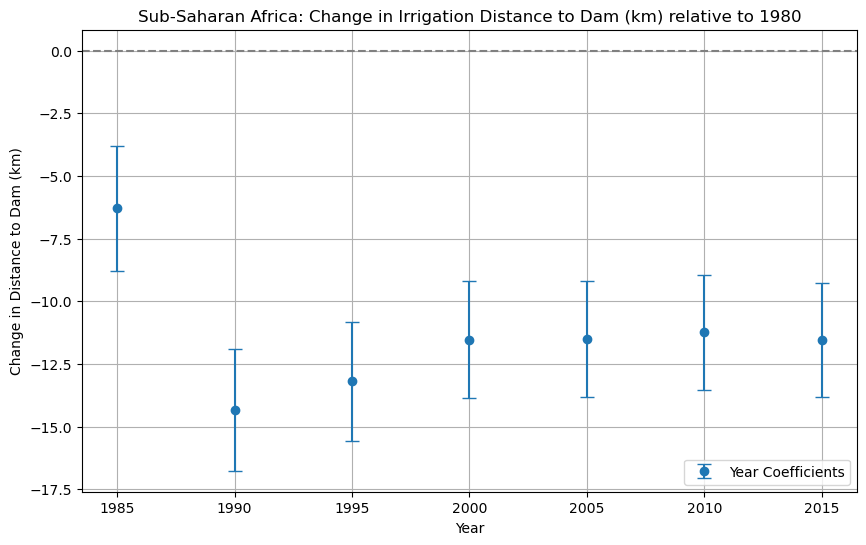

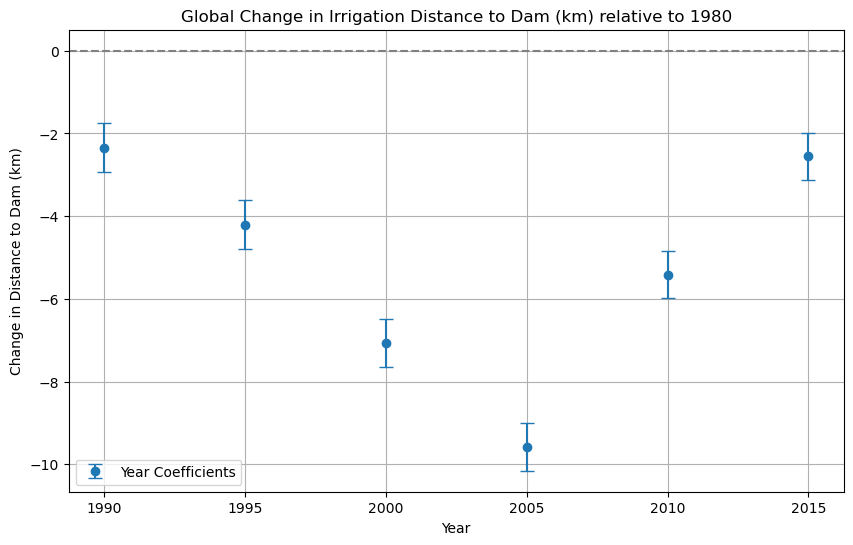

Global annual change in distance of irrigation to dams (2005-2015): 0.6739771754426142
Year p-value: 3.7722192081258314e-135
Year 95% confidence interval: 0    0.620594
1    0.727360
Name: Year, dtype: float64


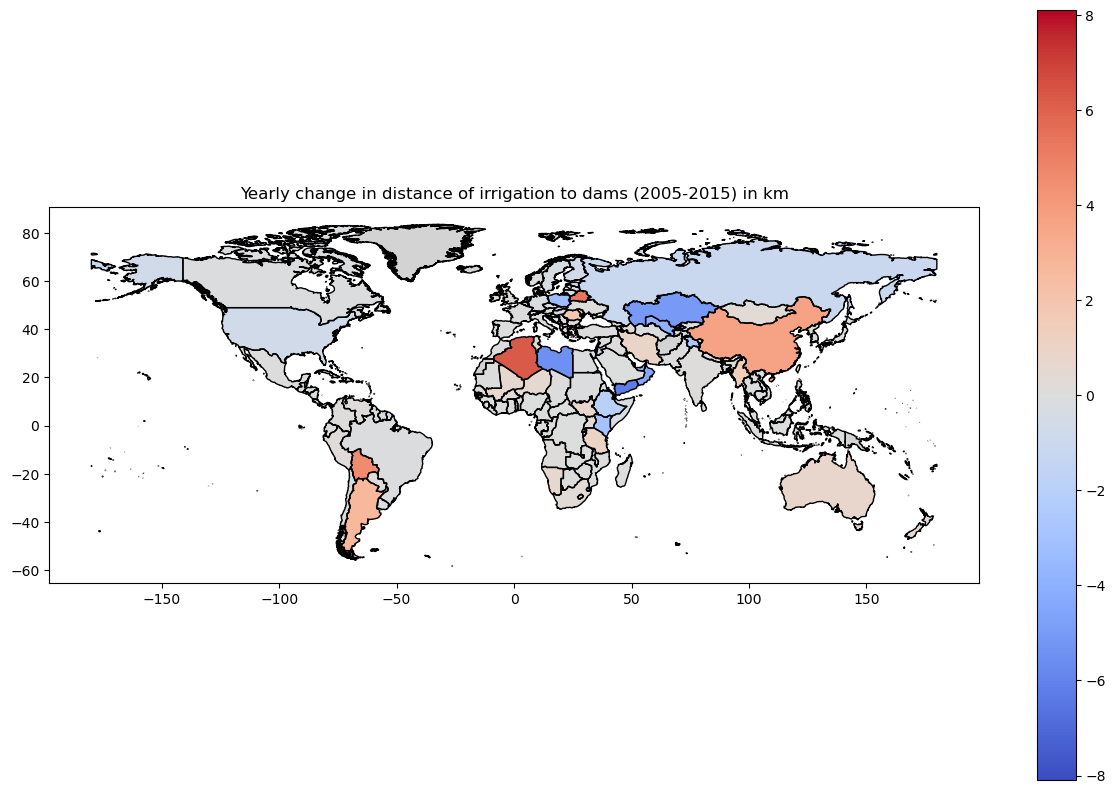

In [78]:
# read in the mehta data. Specifically only read in the columns we need: lat, lon, year, aei, distance to dam, and name (country)
source = 'Meier'
all_aei = []
for year in years: 
    aei_path = os.path.join(data_loc, 'anna', 'intermediate', 'aei_with_dams', f'{source}_aei_{year}.shp')
    aei = gpd.read_file(aei_path, usecols=['Longitude', 'Latitude', 'Year', 'AEI', 'name', 'in_ssa', 'distance_t'])
    aei = aei.rename(columns={'name': 'country', 'distance_t': 'distance_to_dam_km'})
    all_aei.append(aei)

all_aei_combined = pd.concat(all_aei, ignore_index=True)

# How irrigation distance to dams has been changing over time in SSA
model = smf.wls('distance_to_dam_km ~ C(Year) + C(country)', data=aei_in_ssa, weights=aei_in_ssa['AEI']).fit()
# Step 2: Extract the coefficients and confidence intervals for Year
year_coeffs = model.params.filter(like='C(Year)')
year_conf_int = model.conf_int().loc[model.conf_int().index.str.contains('Year')]

# Correcting the year labels by stripping 'T.'
years = [int(term.split('T.')[1].split(']')[0]) for term in year_coeffs.index]

# Extract lower and upper bounds of confidence intervals
ci_lower = year_conf_int[0].values
ci_upper = year_conf_int[1].values

# Step 3: Plot the coefficients with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(years, year_coeffs.values, yerr=[year_coeffs.values - ci_lower, ci_upper - year_coeffs.values], fmt='o', capsize=5, label='Year Coefficients')
plt.axhline(0, color='grey', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Change in Distance to Dam (km)')
plt.title('Sub-Saharan Africa: Change in Irrigation Distance to Dam (km) relative to 1980')
plt.grid(True)
plt.legend()
plt.show()

# How irrigation distance to dams has been changing over time globally
model = smf.wls('distance_to_dam_km ~ C(Year) + C(country)', data=all_aei_combined, weights=all_aei_combined['AEI']).fit()
# Step 2: Extract the coefficients and confidence intervals for Year
year_coeffs = model.params.filter(like='C(Year)')
year_conf_int = model.conf_int().loc[model.conf_int().index.str.contains('Year')]

# Correcting the year labels by stripping 'T.'
years = [int(term.split('T.')[1].split(']')[0]) for term in year_coeffs.index]

# Extract lower and upper bounds of confidence intervals
ci_lower = year_conf_int[0].values
ci_upper = year_conf_int[1].values

# Step 3: Plot the coefficients with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(years, year_coeffs.values, yerr=[year_coeffs.values - ci_lower, ci_upper - year_coeffs.values], fmt='o', capsize=5, label='Year Coefficients')
plt.axhline(0, color='grey', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Change in Distance to Dam (km)')
plt.title('Global Change in Irrigation Distance to Dam (km) relative to 1980')
plt.grid(True)
plt.legend()
plt.show()

# Distance to dams trend from 2005 to 2015 -- globally and by country
# Filter the data to only include years 2005 to 2015
aei_2005_2015 = all_aei_combined[(all_aei_combined['Year'] >= 2005) & (all_aei_combined['Year'] <= 2015)]
model = smf.wls('distance_to_dam_km ~ Year + C(country)', data=aei_2005_2015, weights=aei_2005_2015['AEI']).fit()
print(f"Global annual change in distance of irrigation to dams (2005-2015): {model.params['Year']}")
print(f"Year p-value: {model.pvalues['Year']}")
print(f"Year 95% confidence interval: {model.conf_int().loc['Year']}")

# Load the country boundaries
world_boundaries_path = os.path.join(raw_data_dir, 'world_boundaries', 'world-administrative-boundaries.shp')
world_boundaries = gpd.read_file(world_boundaries_path)

# What part of the globe is driving the upward trend from 2005 to 2015? 

# Run the regression but allow for interaction between year and country -- assume linear trend from 2005 to 2015
model = smf.wls('distance_to_dam_km ~ Year * C(country)', data=aei_2005_2015, weights=aei_2005_2015['AEI']).fit()

# Step 2: Extract the country-specific year interaction terms
interaction_terms = model.params.filter(like='Year:C(country)')

# Clean the country names from the interaction terms, assuming format like 'Year:C(country)[T.USA]'
countries = [term.split('T.')[1].split(']')[0] for term in interaction_terms.index]
coefficients = interaction_terms.values + model.params['Year']

# Step 3: Load the world boundaries shapefile
world_boundaries = gpd.read_file(world_boundaries_path)

# Create a DataFrame with the country coefficients
coef_df = pd.DataFrame({
    'country': countries,
    'coefficient': coefficients
})

# Merge the coefficients with the world boundaries GeoDataFrame
world_boundaries = world_boundaries.merge(coef_df, left_on='name', right_on='country', how='left')

# Get the min and max for the color scale, and ensure zero is in the middle
vmin = world_boundaries['coefficient'].min()
vmax = world_boundaries['coefficient'].max()
abs_max = max(abs(vmin), abs(vmax))

# Step 4: Plot the map with country-specific year coefficients
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_boundaries.boundary.plot(ax=ax, linewidth=1, color='black')
world_boundaries.plot(column='coefficient', ax=ax, legend=True, cmap='coolwarm', vmin=-abs_max, vmax=abs_max, missing_kwds={'color': 'lightgrey'})

plt.title('Yearly change in distance of irrigation to dams (2005-2015) in km')
plt.show()